In [62]:
import xarray as xr
import numpy as np
import plotly.express as px

In [63]:
data = xr.load_dataset("../../2_processed/calcofi_zooplankton.zarr", engine="zarr")
data

<xarray.Dataset> Size: 353MB
Dimensions:      (is_day: 2, latitude: 55, longitude: 103, time: 7796)
Coordinates:
  * is_day       (is_day) bool 2B False True
  * latitude     (latitude) float64 440B 0.5 1.5 2.5 3.5 ... 51.5 52.5 53.5 54.5
  * longitude    (longitude) float64 824B -179.5 -178.5 -177.5 ... -78.5 -77.5
  * time         (time) datetime64[ns] 62kB 1951-01-09 1951-01-10 ... 2023-01-25
Data variables:
    zooplankton  (time, is_day, latitude, longitude) float32 353MB nan ... nan

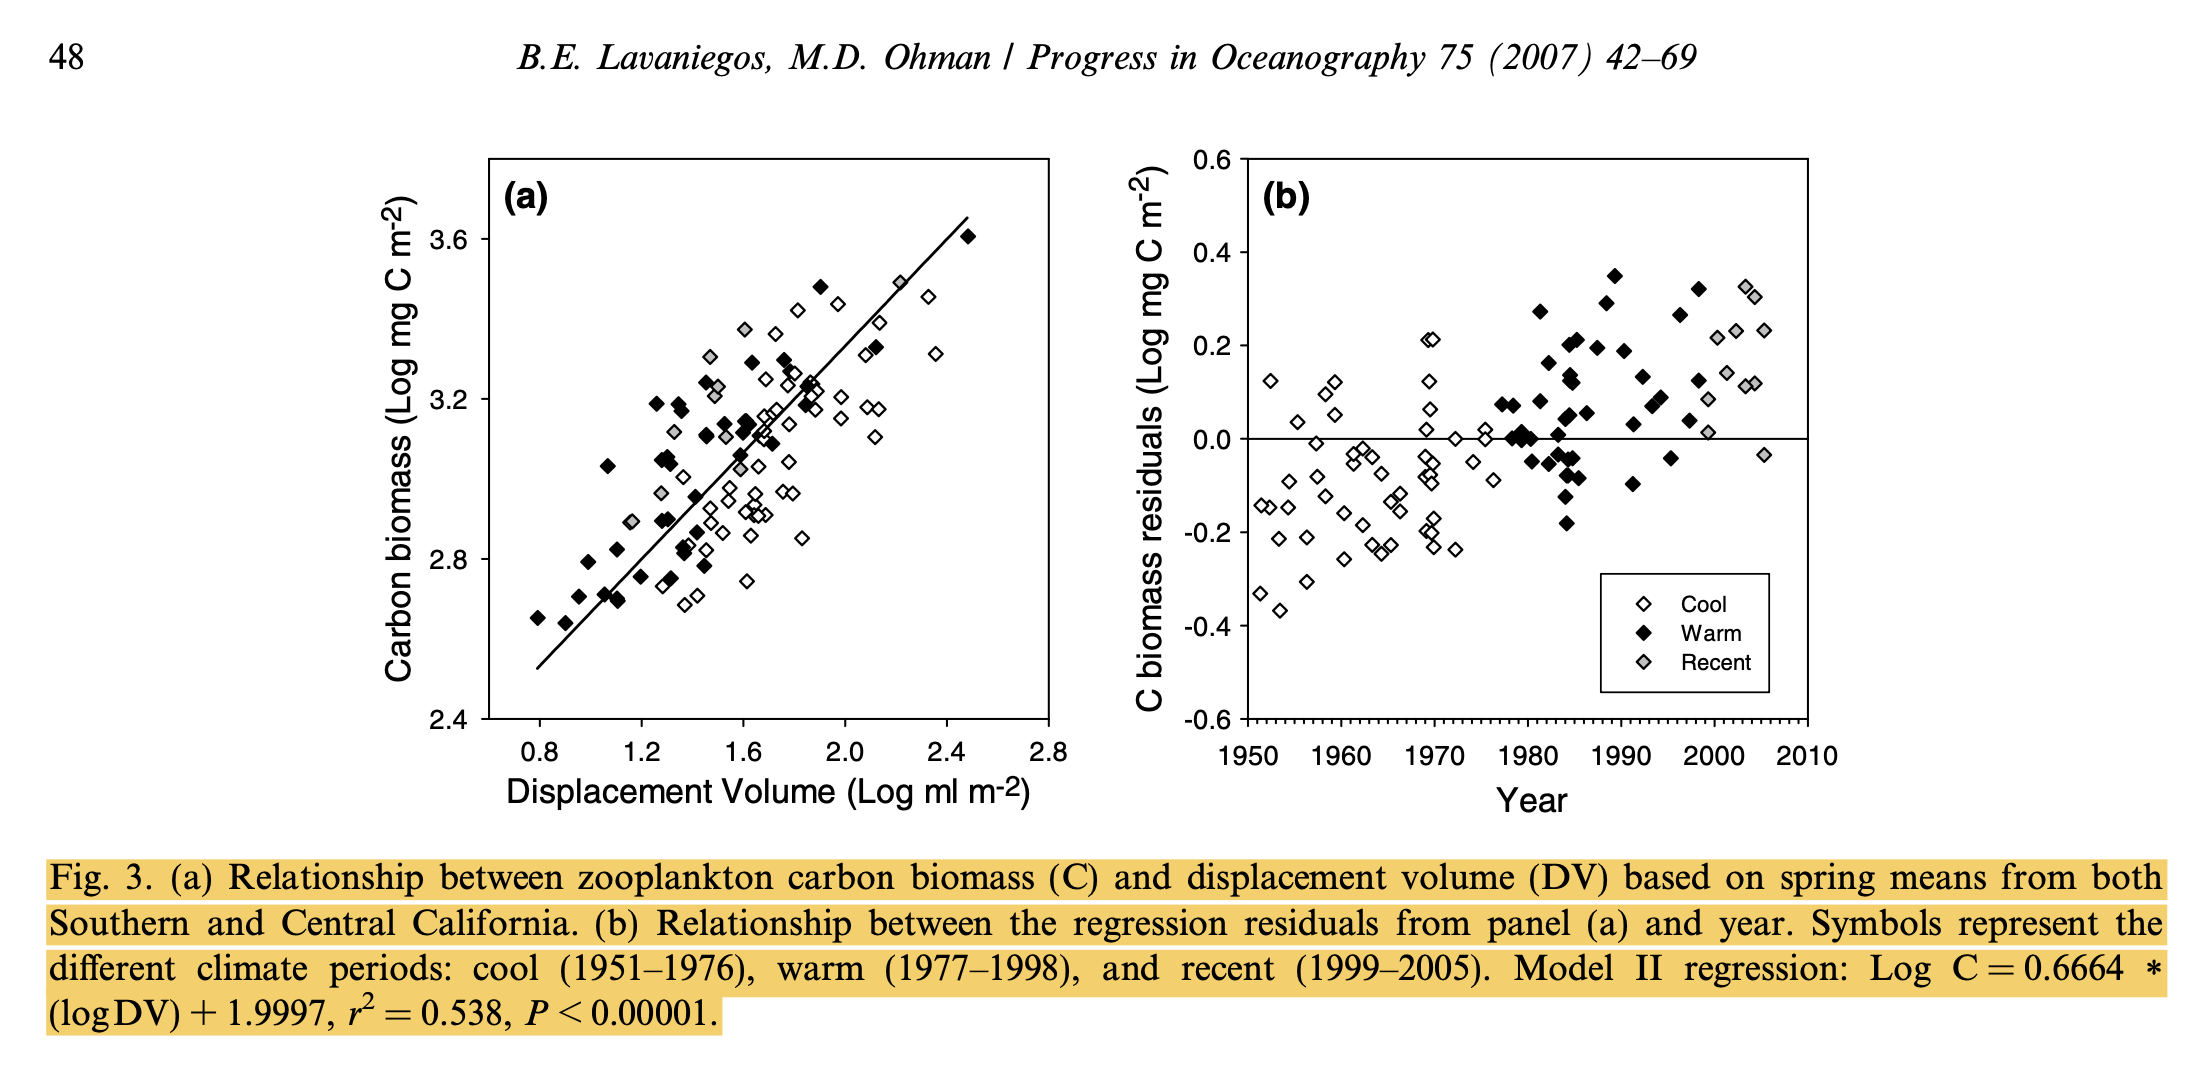


In [64]:
def displacement_volum_to_biomass(volume):
    log_carbon = 0.6664 * np.log(volume) + 1.9997
    return 10 ** (log_carbon)

In [65]:
test = (
    data.mean(["latitude", "longitude"])
    .resample({"time": "1ME"})
    .mean()
    .to_dataframe()
    .dropna()
)
test

zooplankton
is_day time                   
False  1951-01-31   294.178314
       1951-02-28   293.651672
       1951-03-31   165.008331
       1951-04-30   203.129166
       1951-05-31   148.697235
...                        ...
True   2021-02-28   554.833313
       2021-05-31   200.558334
       2022-04-30   208.928574
       2022-10-31   101.000000
       2023-01-31   236.504608

[970 rows x 1 columns]

In [66]:
# Calcul des quartiles
Q1 = test["zooplankton"].quantile(0.25)
Q3 = test["zooplankton"].quantile(0.75)
IQR = Q3 - Q1

# Définir les limites pour détecter les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les données pour enlever les outliers
test = test[(test["zooplankton"] >= lower_bound) & (test["zooplankton"] <= upper_bound)]
test

zooplankton
is_day time                   
False  1951-01-31   294.178314
       1951-02-28   293.651672
       1951-03-31   165.008331
       1951-04-30   203.129166
       1951-05-31   148.697235
...                        ...
True   2021-01-31   155.944443
       2021-05-31   200.558334
       2022-04-30   208.928574
       2022-10-31   101.000000
       2023-01-31   236.504608

[894 rows x 1 columns]

In [67]:
px.box(test.reset_index(), x="is_day", y="zooplankton")


In [76]:
px.line(
    test.reset_index(),
    x="time",
    y="zooplankton",
    color="is_day",
).update_yaxes(title="Biomass (mg C/1000m3)")

In [83]:
tmp = displacement_volum_to_biomass(test / 1000).reset_index()
tmp["zooplankton"] = tmp["zooplankton"] * 150
px.line(
    tmp,
    x="time",
    y="zooplankton",
    color="is_day",
).update_yaxes(title="Biomass (mg C/150m3)")


In [84]:
px.line(
    displacement_volum_to_biomass(test / 1000).reset_index(),
    x="time",
    y="zooplankton",
    color="is_day",
).update_yaxes(title="Biomass (mg C/150m3)")
